# Mini Project 1: MNSIT Pair Comparison

In [506]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import dlc_practical_prologue as prologue
from torch.nn import functional as F

In [561]:
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(1000)

In [527]:
# train and test classes to categorical
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return torch.Tensor(np.eye(num_classes, dtype='uint8')[y]).type(torch.LongTensor)
train_classes, test_classes = to_categorical(train_classes, 10), to_categorical(test_classes, 10)

In [683]:
# function to compute classes accuracy
def accuracy_classes(predicted, target):
    '''
    computes the accuracy of the predicted classes in %
    '''

    predicted_1 = predicted.narrow( 1, 0, 10)
    predicted_2 = predicted.narrow( 1, 10, 10)
    predicted_1 = predicted_1.argmax(dim=1)
    predicted_2 = predicted_2.argmax(dim=1)
    target_1=target[:,0]
    target_2=target[:,1]
    return ( 100-( ( (target_1 != predicted_1) | (target_2 != predicted_2 ) ).sum() ).item() /target_1.shape[0] * 100)

# test:
print(accuracy_classes( model(test_input.narrow(0,0,5))[0], test_classes.narrow(0,0,5))  ) 
accuracy_classes( test_classes_binary.narrow(0,0,5), test_classes.narrow(0,0,5))    

0.0


0.0

In [669]:
model(test_input.narrow(0,0,5))[0]

tensor([[ 0.1999,  0.0401,  0.2855, -0.0391, -0.3504,  0.0983,  0.2851,  0.0000,
          0.2810,  0.0000, -0.0339,  0.6586,  0.0651, -0.2410, -0.2479, -0.0866,
          0.1012, -0.0000,  0.1401, -0.0448],
        [-0.0041, -0.0178, -0.0000, -0.0504,  0.5869, -0.2315, -0.2064, -0.0739,
          0.0515, -0.0636, -0.1815, -0.0829, -0.2509,  0.2774,  0.0000, -0.0154,
         -0.1106, -0.0228, -0.3577,  0.6436],
        [-0.3464,  0.6299, -0.1265,  0.0000, -0.3632,  0.4243, -0.2138, -0.1000,
         -0.3689,  0.6202,  0.5072,  0.0091,  0.1067, -0.0089, -0.0807, -0.0217,
         -0.0613,  0.0156,  0.1312, -0.0073],
        [ 0.4040, -0.0410,  0.0000, -0.0328,  0.2466, -0.0562,  0.2854,  0.0784,
          0.1883,  0.0626, -0.1095, -0.0410,  0.0052, -0.0000, -0.2408,  0.0000,
         -0.1645, -0.0710,  0.0960, -0.0147],
        [ 0.2492, -0.0866,  0.0000, -0.0289,  0.4086,  0.1514,  0.3691, -0.0513,
          0.3451, -0.0000,  0.3205, -0.0192,  0.5708,  0.5080,  0.4465, -0.0501,
      

In [652]:
def accuracy_comparison(predicted, target):
    '''computes accuracy for output'''
    return( (torch.abs(predicted - target) < 0.5).sum().float() / target.shape[0] * 100)

# test:
print(accuracy_comparison(CNN()(test_input.narrow(0,0,5))[1], test_target.narrow(0,0,5).float())  ) 
accuracy_comparison( test_target.narrow(0,0,5), test_target.narrow(0,0,5))    

tensor(60.0000)


tensor(0.)

In [653]:
# test 
accuracy_comparison(torch.Tensor([0.5574]), torch.Tensor([0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
        0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.,
        0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
        1., 1., 1., 0., 1., 1., 1., 0., 0., 0.]))

tensor(52.)

In [705]:
# define the model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=8,            # n_filters
                kernel_size=2,              # filter size
                stride=1,                   # filter movement/step
                padding=4,                  # if want same width and length of this image after Conv2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(8, 8, 5, 1, 4),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )


        self.fc1 = nn.Sequential(
            nn.Linear(8 * 7 * 7, 20),  # fully connected layer, output 10 classes
            nn.ReLU(),  
        )
        self.fc2 = nn.Sequential(
            nn.Linear(20, 10) ,  # fully connected layer, output 10 classes
            nn.ReLU(),  
        )
        self.fc3 = nn.Sequential(
            nn.Linear(20, 1) ,  # fully connected layer, output 10 classes
            nn.Sigmoid(),  
        )
        '''
        self.fc4 = nn.Sequential(
            nn.Linear(100, 1) ,  # fully connected layer, output 10 classes
            nn.Sigmoid(),  
        )
'''
    def forward(self, x):
        #first convolutional layer
        _x = torch.reshape(x[:,0,:,:], (-1, 1, 14, 14))
        _x1 = self.conv1(_x)
        _x = torch.reshape(x[:,1,:,:], (-1, 1, 14, 14))
        _x2 = self.conv1(_x)

        #second convolutional layer

        _x1 = self.conv2(_x1)
        _x2 = self.conv2(_x2)

        #flatten images
        _x1 = _x1.view(_x1.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        _x2 = _x2.view(_x2.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)

        #first fc layer
        _x1 = F.relu(self.fc1(_x1))
        _x2 = F.relu(self.fc1(_x2))

        #second fc layer
        _x1 = self.fc2(_x1)
        _x2 = self.fc2(_x2)

        #concatenate and retrun auxilary output
        _x = torch.cat((_x1, _x2), 1)   
        aux_out = _x



        #third and fourth fc layer
        _x = self.fc3(_x)
        #_x = self.fc4(_x)
        return  aux_out, _x.view(1,-1)
print(CNN())

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(2, 2), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=392, out_features=20, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=20, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


epoch: (../ 300 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 

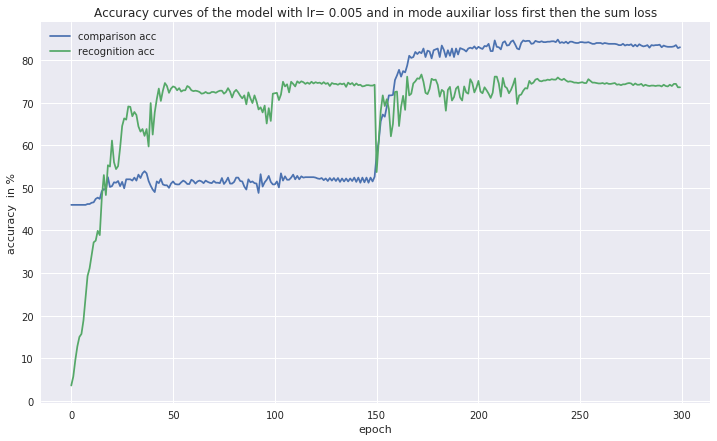

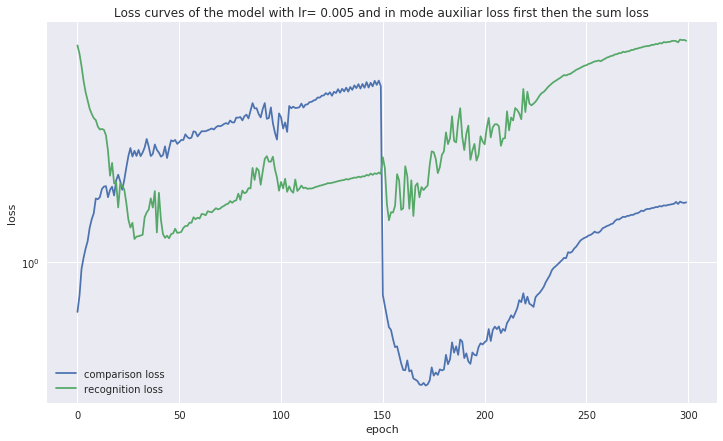

epoch: (../ 300 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 

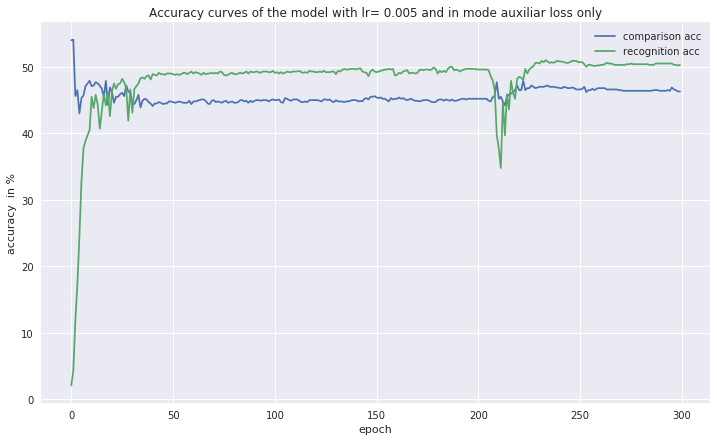

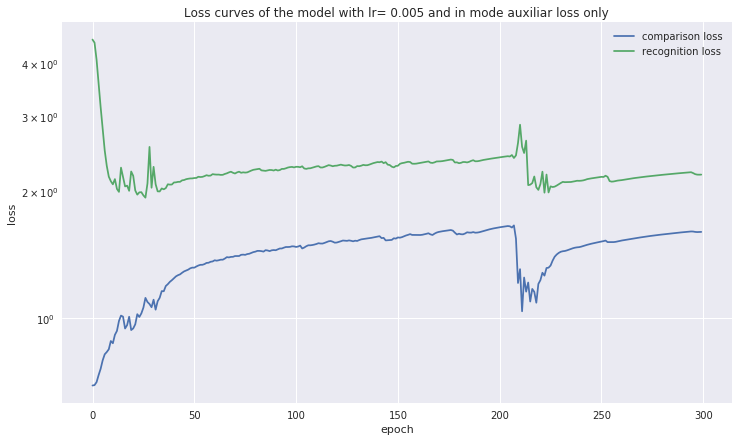

epoch: (../ 300 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 

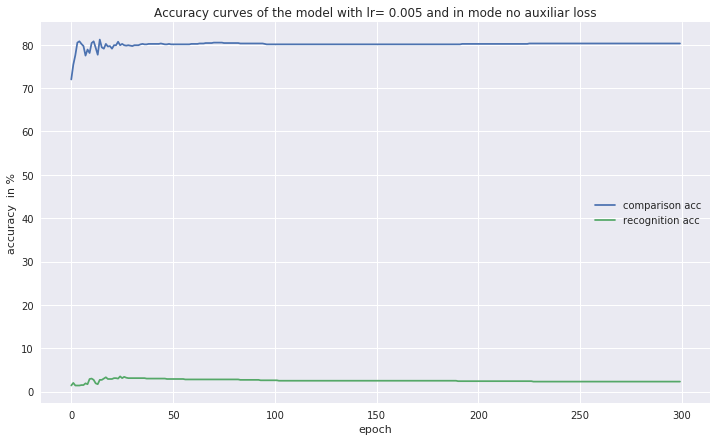

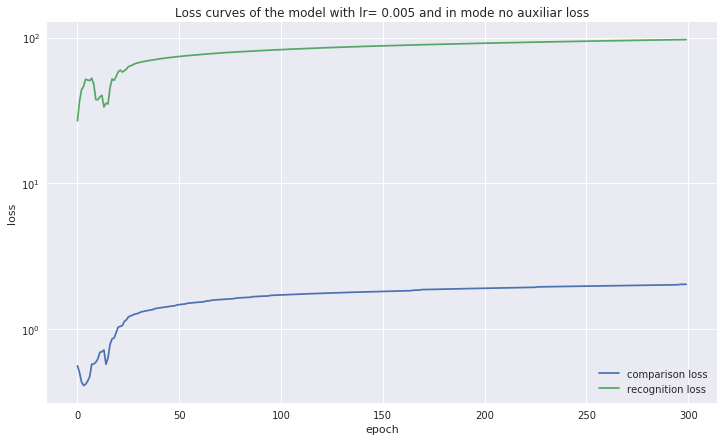

epoch: (../ 300 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 

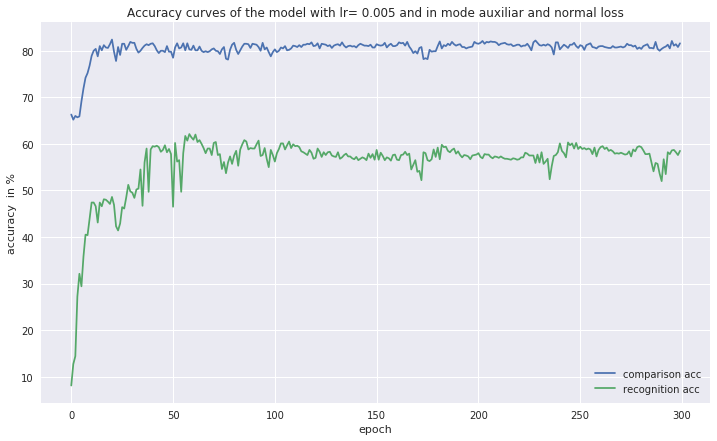

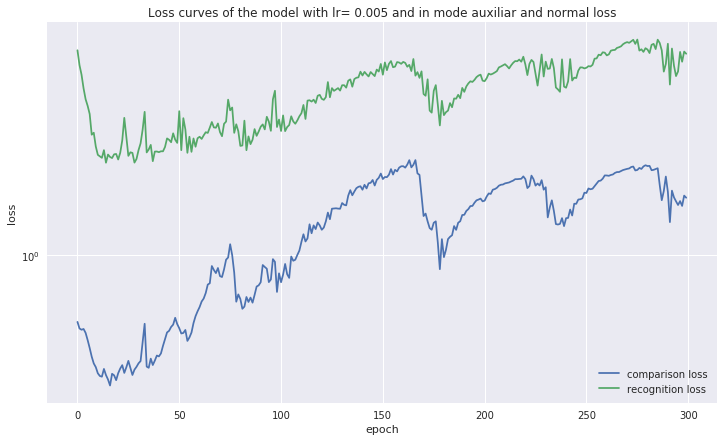

epoch: (../ 300 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 

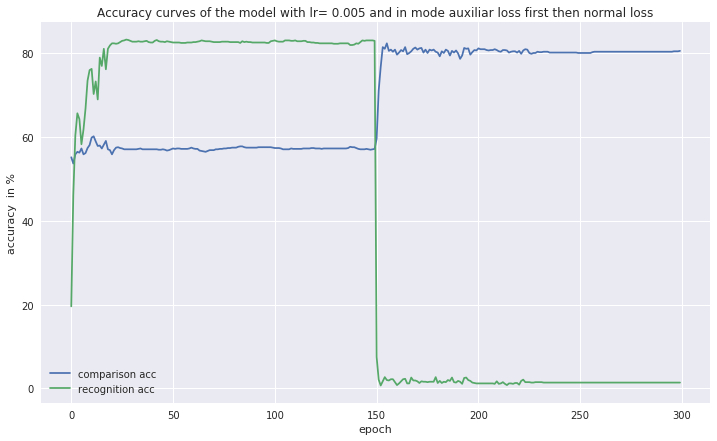

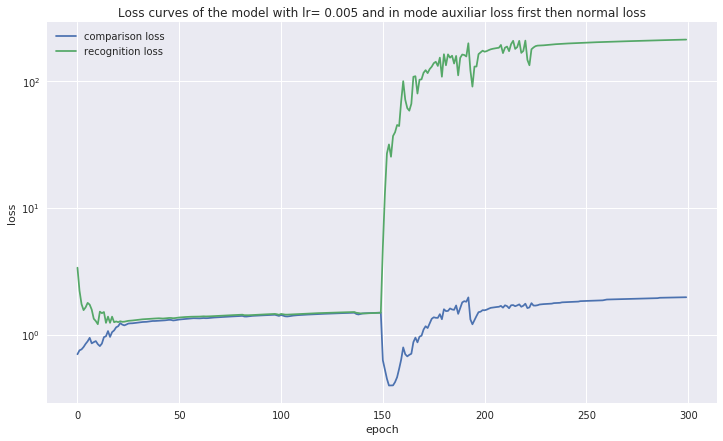

epoch: (../ 300 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 

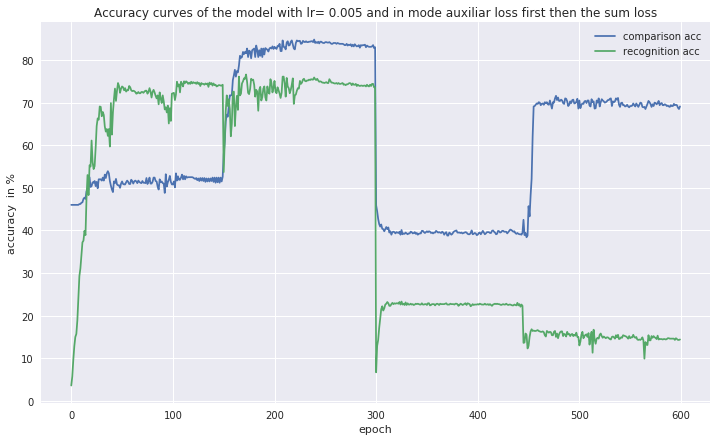

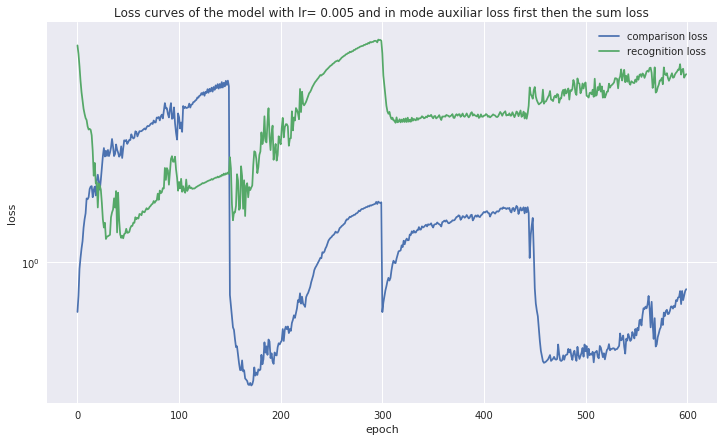

In [712]:
# Training of the model
modes = ['auxiliar loss only', 'no auxiliar loss', 'auxiliar and normal loss', 'auxiliar loss first then normal loss', 'auxiliar loss first then the sum loss' ]
data = {}


for mode in modes:
    data[mode]={
        'recognition loss':[],
        'recognition acc':[],
        'comparison loss':[],
        'comparison acc': [],
    }

def run(mode):
    
    if mode == 'auxiliar loss only':
        loss_function = lambda main_loss, aux_loss, e :  aux_loss

    if mode == 'no auxiliar loss':
        loss_function = lambda main_loss, aux_loss,e :  main_loss

    if mode == 'auxiliar and normal loss':
        loss_function = lambda main_loss, aux_loss, e :  main_loss + aux_loss

    if mode == 'auxiliar loss first then normal loss':
        loss_function = lambda main_loss, aux_loss, epoch: aux_loss    if ( epoch < epochs /2) else main_loss

    if mode == 'auxiliar loss first then the sum loss':
        loss_function = lambda main_loss, aux_loss, epoch: aux_loss    if ( epoch < epochs /2) else main_loss + aux_loss



    eta= 0.005
    mini_batch_size = 100
    epochs = 300

    model = CNN()
    criterion_aux = nn.CrossEntropyLoss() # criterion for digit recognition
    criterion_main = torch.nn.BCELoss() # criterion for digit comparison

    # use adam optimizer for SGD
    optimizer = torch.optim.Adam(model.parameters(), lr=eta)

    # compute minibatch test target
    minibatch_test_target = test_target.narrow(0, 0, mini_batch_size)
    minibatch_test_input = test_input.narrow(0, 0, mini_batch_size)

    # print total number of epochs
    print('epoch: (../ '+str(epochs)+' )')
    
    for e in range(0, epochs):
        #print current epoch
        print(str(e), sep=' ', end=' ', flush=True)

        # We do this with mini-batches
        for b in range(0, train_input.size(0), mini_batch_size):

            mini_batch_input = train_input.narrow(0, b, mini_batch_size)
            mini_batch_target = train_target.narrow(0, b, mini_batch_size) #classification labels Nx1
            mini_batch_target_aux = train_classes.narrow(0, b, mini_batch_size) #binary 'what number are these images' Nx20


            #output_aux is the Nx20 output of the second fc layer corresponding to what image pairs were predicted
            #output is the Nx1 output corresponding to: if image 0 or image 1 is bigger
            output_aux, output = model(mini_batch_input)  
            
            loss_aux = criterion_aux(output_aux[:,10:], mini_batch_target_aux[:,1])
            loss_main = criterion_main(output[0,:], mini_batch_target.float())

            optimizer.zero_grad()
            loss = loss_function( loss_main, loss_aux, e)
            loss.backward()
            optimizer.step()



        # compute validation loss and accuracy
        
        with torch.no_grad():
            
            
            #compute outputs for test data
            validation_output_aux, validation_output = model(test_input)

            # compute loss for test data
            main_validation_loss = criterion_main( validation_output[0,:], test_target.float()) 
            aux_validation_loss = criterion_aux(validation_output_aux[:,:10], test_classes[:,0].long()) + criterion_aux(validation_output_aux[:,10:], test_classes[:,1].long())

            # compute accuracy for test and train data
            main_validation_acc_item = accuracy_comparison( validation_output[0,:], test_target.float())
            aux_validation_acc_item = accuracy_classes(validation_output_aux, test_classes)


            # append to arrays
            # save results in d
            d = data[mode]
            
            d['comparison loss'].append(main_validation_loss.item())
            d['recognition loss'].append(aux_validation_loss.item())
            d['comparison acc'].append(main_validation_acc_item)
            d['recognition acc'].append(aux_validation_acc_item)


    
    # plotting accuracy
    plt.figure(figsize=(12,7))

    plt.title('Accuracy curves of the model with lr= '+str(eta)
               +' and in mode '+mode)

    
    plt.plot(d['comparison acc'], label='comparison acc')
    plt.plot(d['recognition acc'], label='recognition acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy  in %')
    plt.show()
    
    # plotting loss
    plt.figure(figsize=(12,7))

    plt.title('Loss curves of the model with lr= '+str(eta)
               +' and in mode '+mode)

    
    plt.plot(d['comparison loss'], label='comparison loss')
    plt.plot(d['recognition loss'], label='recognition loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.show()
    
run('auxiliar loss first then the sum loss')
for mode in modes:
    run(mode)

In [700]:
train_e, train_pred = errorr(model, train_input, train_target, mini_batch_size)

test_e, test_pred = errorr(model, test_input, test_target, mini_batch_size)

print('Train error:', train_e/train_input.size(0))

print('Test error:', test_e/test_input.size(0))

print('Number of parameters:', sum(p.numel() for p in CNN().parameters() if p.requires_grad)) 

Train error: 0.391
Test error: 0.41
Number of parameters: 17979


# Take a look at the input vs prediction

### TRAIN

In [428]:
train_target[:100]

tensor([0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 1])

In [429]:
train_pred[0] #predicted pairs in training for first mini batch of 100

#first 15 elements of each vector below are left and right columns above, repsectively

tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 1])

Print image pairs if you want

In [430]:
#for i in range(10):
#    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#    ax1.imshow(train_input[i,0,:,:].cpu(), cmap='gray', interpolation='none')
#    ax2.imshow(train_input[i,1,:,:].cpu(), cmap='gray', interpolation='none')

#    plt.show()

In [431]:
#train_classes_binary_0[:10]

In [432]:
#train_classes_binary_1[:10]

### TEST

In [433]:
test_target[:100]

tensor([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 1])

In [434]:
test_pred[0] #predicted pairs in testing for first mini batch of 100

tensor([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1])

Primt image pairs if you want

In [435]:
#for i in range(10):
#    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#    ax1.imshow(test_input[i,0,:,:].cpu(), cmap='gray', interpolation='none')
#    ax2.imshow(test_input[i,1,:,:].cpu(), cmap='gray', interpolation='none')

#    plt.show()

In [436]:
#test_classes_binary_0[:10]

In [437]:
#test_classes_binary_1[:10]